## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from model import resolve_single
from data import DIV2K
from utils import load_image
from PIL import Image
import numpy as np

%matplotlib inline

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Downloading and Importing LPIPS

In [3]:
import lpips
import torch

### Importing Simple XESRGAN Model

In [4]:
from model.sxesrgan import generator as sxesrgen
from model.sxesrgan import discriminator as sxesrdisc
from sxesrgantrain import SXESrganTrainer 
from sxesrgantrain import SXESrganGeneratorTrainer 

## Loading Datasets

In [5]:
div2k_train = DIV2K(scale=4, hr_size = 128, subset='train', downgrade='bicubic', images_dir='.div2k/images', caches_dir='.div2k/caches')
div2k_valid = DIV2K(scale=4, hr_size = 128,  subset='valid', downgrade='bicubic', images_dir='.div2k/images', caches_dir='.div2k/caches')

In [6]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

In [7]:
print(tf.__version__)

2.1.0


## Setting Weights Directory

In [8]:
weights_dir = 'trained_weights/sxesrgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)
os.makedirs(weights_dir, exist_ok=True)

## Training SXESRGAN

### Pre-Trainer 

In [9]:
pre_trainer = SXESrganGeneratorTrainer(model=sxesrgen(), checkpoint_dir=f'./ckpt_sxesr/pre_generator')

pre_trainer.train(train_ds,valid_ds, steps=100000, evaluate_every=500, save_best_only = False)

Model restored from checkpoint at step 100000.


In [10]:
pre_trainer.model.save_weights(weights_file('pre_generator.h5'))

### Saving Model

In [11]:
weights_dir = 'trained_models/sxesrgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)
os.makedirs(weights_dir, exist_ok=True)
pre_trainer.model.save(weights_file('sxesrgan.h5'))

### GAN Trainer

In [12]:
gan_generator = pre_trainer.model
gan_discriminator = sxesrdisc(hr_size=128)

In [13]:
gan_trainer = SXESrganTrainer(generator=gan_generator, discriminator=gan_discriminator, checkpoint_dir = './ckpt/sxesrgan_lpips', disc_type = 'ragan', loss_type = 'lpips')
gan_trainer.train(train_ds, evaluate_every=500, steps=20000) 

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: C:\Users\DELL\Anaconda3\lib\site-packages\lpips\weights\v0.1\alex.pth
Model restored from checkpoint at step 2000.
2500/20000, perceptual loss = 1.3962, discriminator loss = 0.7256
3000/20000, perceptual loss = 1.4059, discriminator loss = 0.7257
3500/20000, perceptual loss = 1.3939, discriminator loss = 0.7255
4000/20000, perceptual loss = 1.3570, discriminator loss = 0.7256
4500/20000, perceptual loss = 1.3887, discriminator loss = 0.7256
5000/20000, perceptual loss = 1.3928, discriminator loss = 0.7251
5500/20000, perceptual loss = 1.3625, discriminator loss = 0.7252
6000/20000, perceptual loss = 1.3956, discriminator loss = 0.7247
6500/20000, perceptual loss = 1.3612, discriminator loss = 0.7244
7000/20000, perceptual loss = 1.3638, discriminator loss = 0.7246
7500/20000, perceptual loss = 1.3724, discriminator loss = 0.7245
8000/20000, perceptual loss = 1.3735, discriminator loss = 0.7247
8

KeyboardInterrupt: 

In [14]:
gan_trainer.generator.save_weights(weights_file('gan_generator.h5'))
gan_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))

In [15]:
weights_dir = 'trained_models/sxesrgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)
os.makedirs(weights_dir, exist_ok=True)
gan_trainer.generator.save(weights_file('sxesrgan_generator.h5'))
gan_trainer.discriminator.save(weights_file('sxesrgan_discriminator.h5'))

### Network Interpolation

In [50]:
sxesrpre_generator = sxesrgen()



In [51]:
weights_dir = 'trained_weights/sxesrgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)
sxesrpre_generator.load_weights(weights_file('pre_generator.h5'))

AttributeError: 'str' object has no attribute 'decode'

In [ ]:
weights_dir = 'weights/sxesrgan_lpips'
weights_file = lambda filename: os.path.join(weights_dir, filename)
sxesrgan_generator.load_weights(weights_file('gan_generator.h5'))


In [ ]:
ALPHA = 0.5
sxesrgan = sxesrgen()

vars_psnr = [v.numpy() for v in sxesrpre_generator.trainable_variables]
vars_esrgan = [v.numpy() for v in sxesrgan_generator.trainable_variables]

for i, var in enumerate(sxesrgan.trainable_variables):
  var.assign((1 - ALPHA) * vars_psnr[i] + ALPHA * vars_esrgan[i])

sxesrgan.save_weights(weights_file('gan_interp.h5'))

## Demo

In [4]:
weights_dir = 'trained_weights/sxesrgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

In [16]:
pre_generator = pre_trainer.model
gan_gen = gan_trainer.generator


In [17]:
from model import resolve_single
from utils import load_image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_gen, lr)
    
    plt.figure(figsize=(30, 30))
    
    images = [lr, pre_sr, gan_sr]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

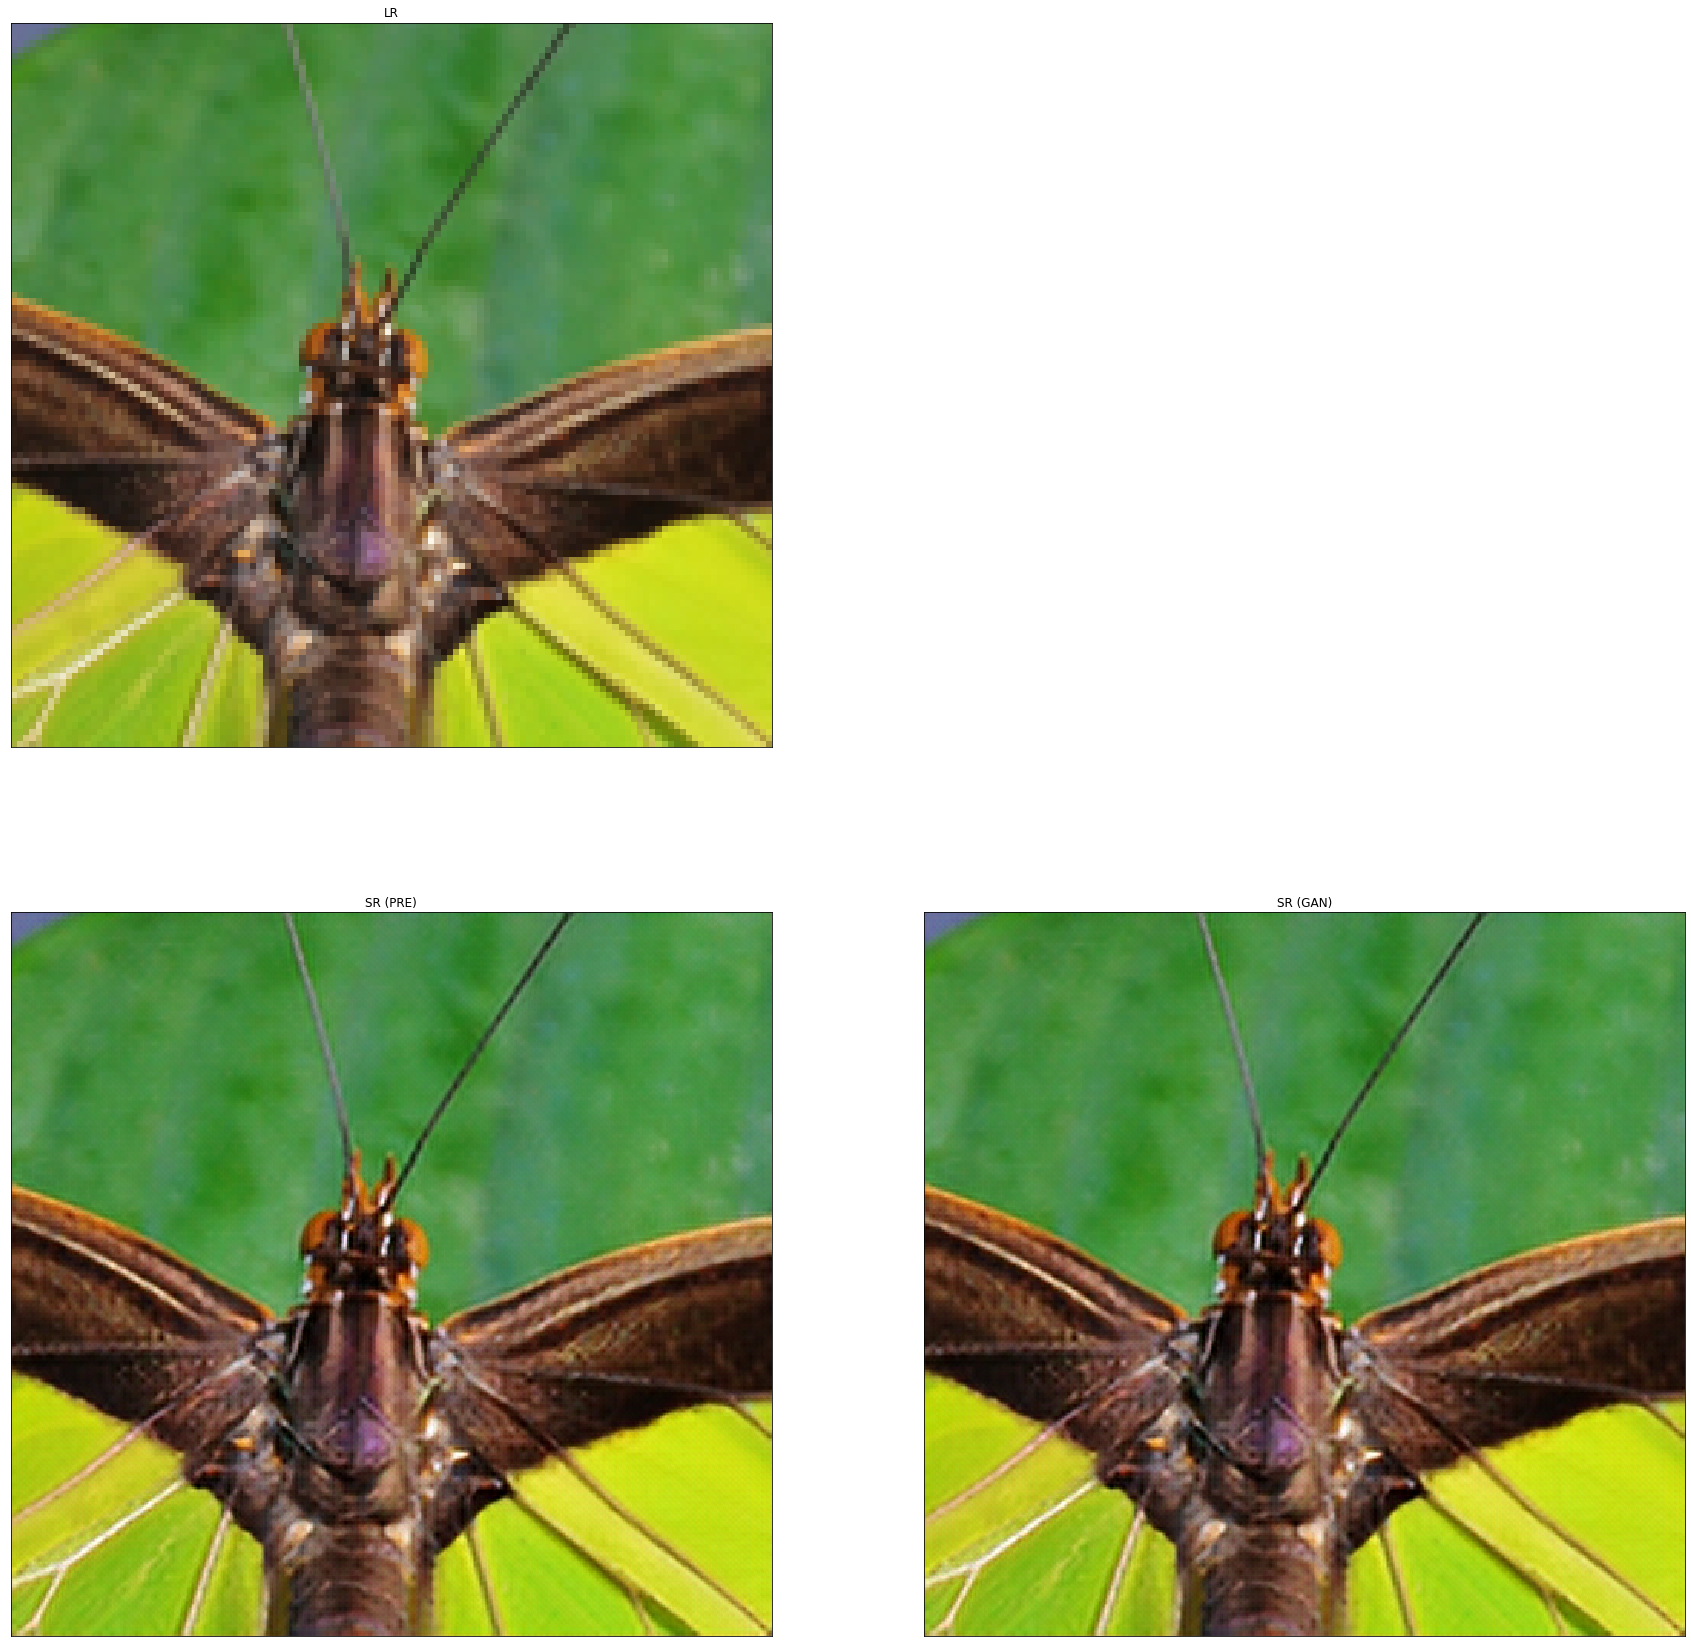

In [18]:
lr_image_path = 'demo/0829x4-crop.png'
resolve_and_plot(lr_image_path)

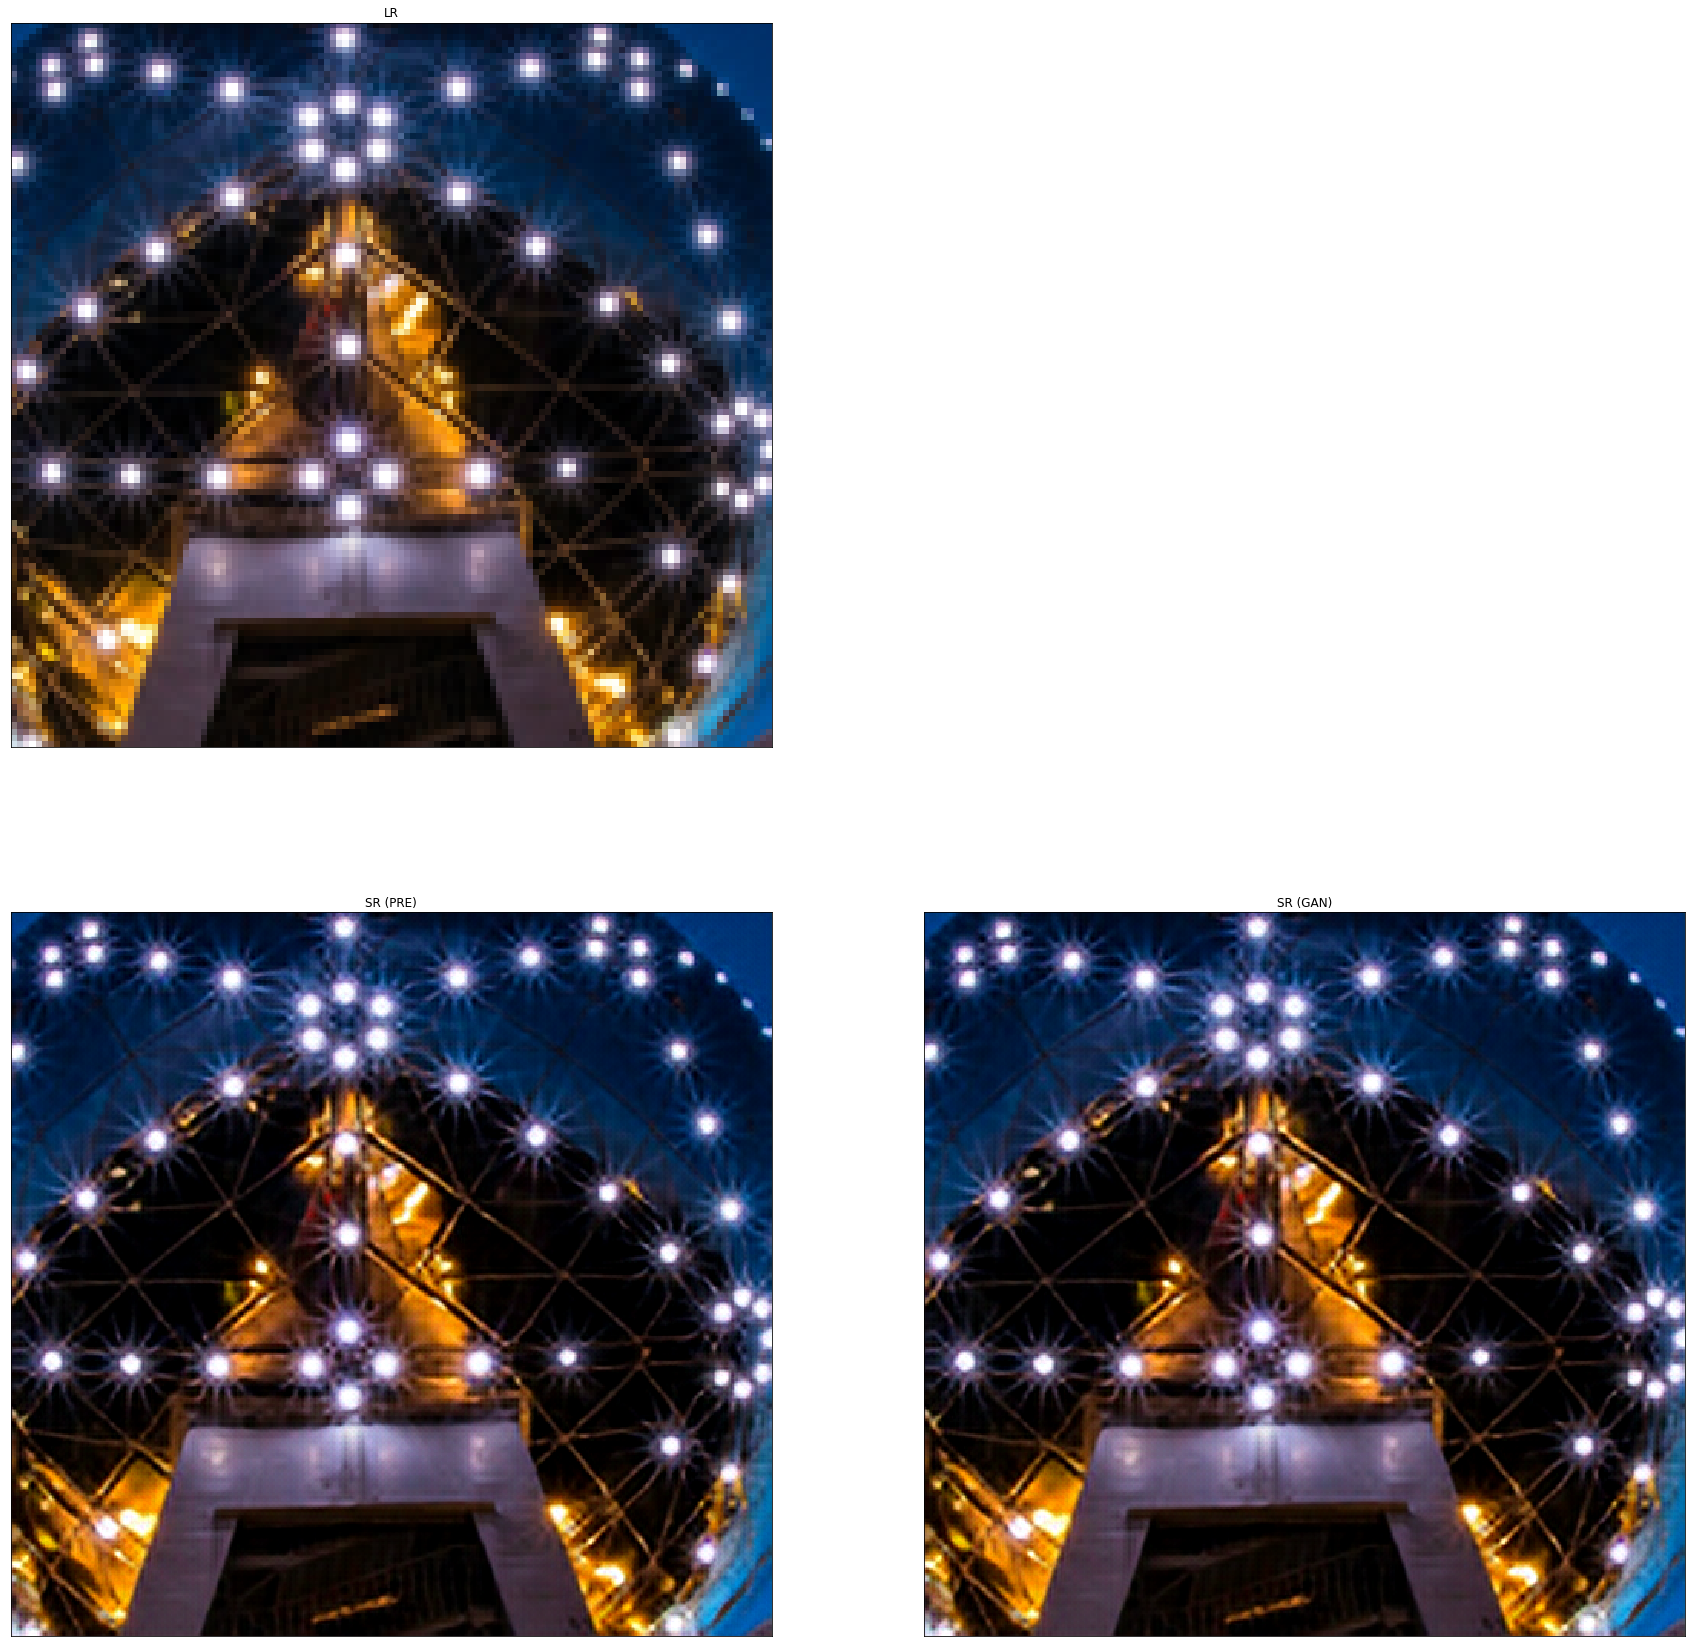

In [19]:
lr_image_path = 'demo/0851x4-crop.png'
resolve_and_plot(lr_image_path)

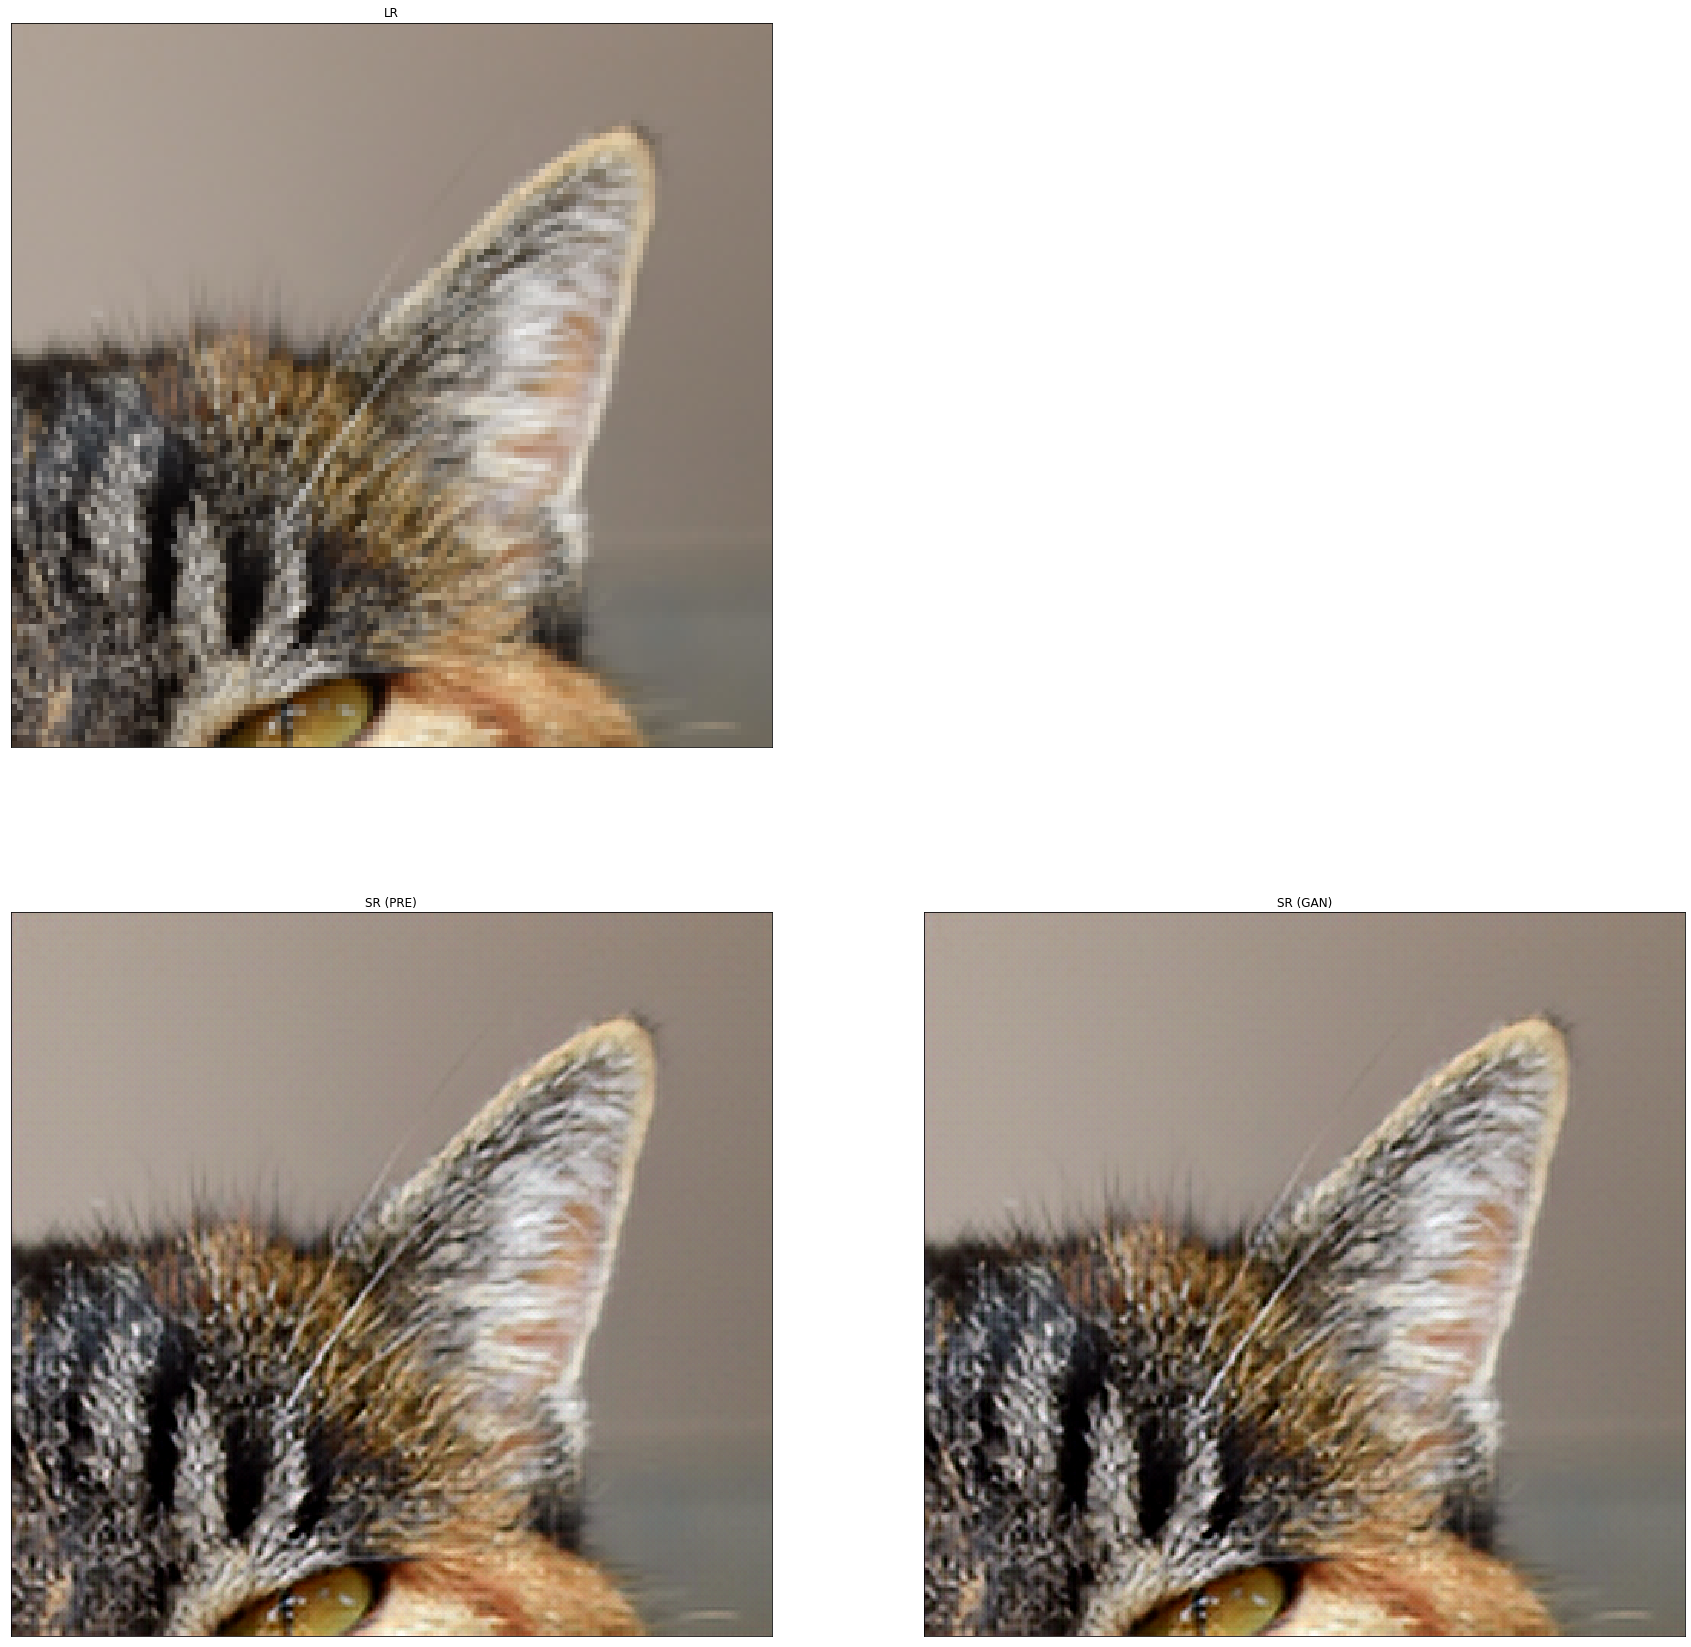

In [20]:
lr_image_path = 'demo/0869x4-crop.png'
resolve_and_plot(lr_image_path)